In [65]:
import torch 
import numpy as np
import pandas as pd
import scanpy as sc
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from scvi.distributions import NegativeBinomial

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch.nn.functional as F

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/scportrait_ot/src")

from dataloader import EmbeddingDecoderDataset
from decoding_modules import DecoderFromHarmony
from pathlib import Path

### Initialize dataset

In [66]:
dataset = EmbeddingDecoderDataset(adata_path="/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/citeseq/CITEseq_rna_processed.h5ad", 
                                     count_label="X_normalized_10k", 
                                     embedding_label="X_harmony_RNA",
                                     batch_label="donor_id")

Initialize dataloaders

In [67]:
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=256,
                                        shuffle=True,
                                        num_workers=4)

### Initialize model 

In [68]:
decoder_model = DecoderFromHarmony(input_dim=dataset.input_dim, 
                                   output_dim=dataset.output_dim,
                                   dims=[256, 256],
                                   batch_norm=False, 
                                   dropout=False,
                                   dropout_p=0.0, 
                                   batch_encoding=False, 
                                   batch_encoding_dim=None,
                                   learning_rate=1e-3,
                                   likelihood="nb"
                                  )

In [69]:
decoder_model

DecoderFromHarmony(
  (decoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=256, out_features=2000, bias=True)
    )
  )
)

In [70]:
decoder_model.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/experiements/decoder_cite_10k/fresh-cosmos-1/checkpoints/last.ckpt")["state_dict"])

<All keys matched successfully>

In [71]:
torch.load("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/experiements/decoder_cite_10k/fresh-cosmos-1/checkpoints/last.ckpt")["state_dict"]

OrderedDict([('theta',
              tensor([-3.1794, -0.5729, -1.1030,  ..., -2.2732,  0.3562, -2.2861],
                     device='cuda:0')),
             ('decoder.net.0.weight',
              tensor([[-0.0857,  0.3362,  0.0178,  ..., -0.0256,  0.1095,  0.2714],
                      [ 0.0410, -0.2000, -0.0023,  ..., -0.1112,  0.0141, -0.1972],
                      [ 0.3574,  0.0556,  0.1268,  ...,  0.2063, -0.2225,  0.1328],
                      ...,
                      [ 0.1470, -0.0902, -0.0692,  ..., -0.0334, -0.0199,  0.1393],
                      [-0.1287,  0.2706, -0.0771,  ..., -0.0927,  0.2700, -0.3178],
                      [ 0.2999,  0.1054, -0.2003,  ...,  0.0922,  0.0359, -0.2262]],
                     device='cuda:0')),
             ('decoder.net.0.bias',
              tensor([-0.8796, -0.2327, -1.1591, -0.1531,  0.7291, -0.9043, -0.3232, -0.9030,
                      -0.7189,  0.0490,  0.1176, -1.0105, -0.6394, -0.1728,  0.2300, -0.6037,
                    

## Check reconstruction  

In [72]:
Xs = []
X_hat = []

with torch.no_grad():
    for batch in dataloader:
        Xs.append(batch["X"])
        size_factor = batch["X"].sum(1, keepdim=True)
        mu_hat = decoder_model.decoder(batch["X_emb"])
        mu_hat = F.softmax(mu_hat, dim=1)
        px = NegativeBinomial(mu=mu_hat * size_factor, theta=torch.exp(decoder_model.theta))
        X_hat.append(px.sample())

In [73]:
X_hat = torch.cat(X_hat, dim=0).cpu().detach().numpy()
Xs = torch.cat(Xs, dim=0).cpu().detach().numpy()
idx = torch.randint(0, X_hat.shape[0], (30000,))
X_hat = X_hat[idx]
Xs = Xs[idx]

In [74]:
obs = pd.DataFrame({"data_type": ["real" for _ in range(30000)]+["reconstructed" for _ in range(30000)]})

In [75]:
adata_generated = sc.AnnData(X=np.concatenate([Xs, X_hat]), 
                            obs=obs)

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [76]:
# sc.pp.normalize_total(adata_generated)
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

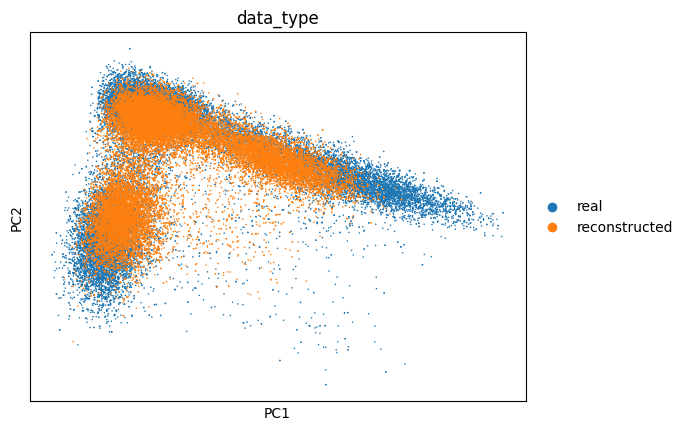

In [77]:
sc.pl.pca(adata_generated, color="data_type", s=5)

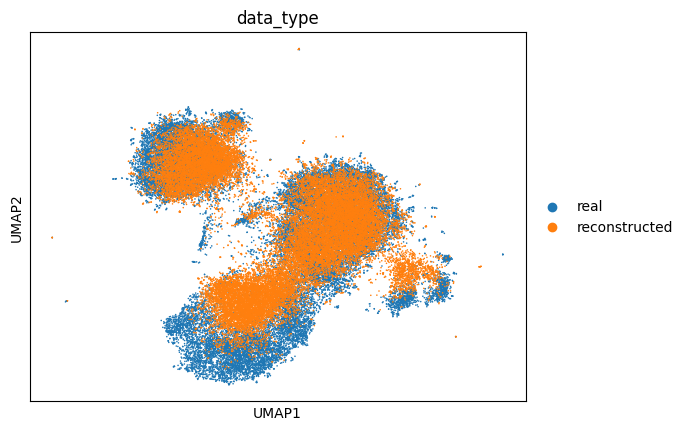

In [78]:
sc.pl.umap(adata_generated, color="data_type", s=5)